The goal of this project is to have a model predict some emotion ratings associated with an image. Pre-trained models will be used on an image set from an emotion study to learn a regression problem.

Below lists the link to the study and link to the image dataset (GAPED) used for the project. <br/>
Link to study: https://link.springer.com/content/pdf/10.3758/s13428-011-0064-1.pdf <br/>
Link to image dataset: https://www.unige.ch/cisa/research/materials-and-online-research/research-material/

For information about transfer learning: https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/ <br/>
Keras models: https://keras.io/api/applications/

In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

**Set the paths for various paths that will be called on.**

In [2]:
data_path='../Data/'
img_path='../Images/'
model_path='../Models/'
results_path='../Results/'

In the study, the images were broken up into 6 types.

There were four specific negative content: <br/>
**A:** Animal mistreatment<br/>
**H:** Human rights violation<br/>
**Sn:** Snakes <br/>
**Sp:** Spiders

**Positive** images contain: Human and animal babies, and nature sceneries <br/>
**Neutral** images contain: Inanimate objects


Each image had human ratings on some emotion measures.

In [3]:
#Reading in all the results from the study
A=pd.read_csv(data_path+'Study Results/A.txt', sep='\t')
H=pd.read_csv(data_path+'Study Results/H.txt', sep='\t')
N=pd.read_csv(data_path+'Study Results/N.txt', sep='\t')
P=pd.read_csv(data_path+'Study Results/P.txt', sep='\t')
Sn=pd.read_csv(data_path+'Study Results/Sn.txt', sep='\t')
Sp=pd.read_csv(data_path+'Study Results/Sp.txt', sep='\t')

In [4]:
#The same files as above, but with standard deviations for each human-inputted ratings
A_sd=pd.read_csv(data_path+'Study Results/A_with SD.txt', sep='\t')
H_sd=pd.read_csv(data_path+'Study Results/H_with SD.txt', sep='\t')
N_sd=pd.read_csv(data_path+'Study Results/N_with SD.txt', sep='\t')
P_sd=pd.read_csv(data_path+'Study Results/P_with SD.txt', sep='\t')
Sn_sd=pd.read_csv(data_path+'Study Results/Sn_with SD.txt', sep='\t')
Sp_sd=pd.read_csv(data_path+'Study Results/Sp_with SD.txt', sep='\t')

In [5]:
#Combining results together
df=pd.concat([A,H,N,P,Sn,Sp], axis=0).reset_index(drop=True)

In [6]:
#Combining the results that has standard deviations together
df_sd=pd.concat([A_sd,H_sd,N_sd,P_sd,Sn_sd,Sp_sd], axis=0).reset_index(drop=True)

In [7]:
#Check dataframe
df.head()

,Unnamed: 0,Valence,Arousal,Internal norms,External norms
0,A001.jpg,2.553,74.995,12.289429,16.409175
1,A002.jpg,45.698,56.948,75.412445,78.690491
2,A004.jpg,36.197,55.567,40.215111,63.345528
3,A005.jpg,43.439,48.905,51.038688,40.093340
4,A006.jpg,27.544,67.897,22.594799,31.434631


In [8]:
#Check dataframe with standard deviations
df_sd.head()

,Unnamed: 0,Valence,(SD),Unnamed: 3,Arousal,(SD).1,Unnamed: 6,Internal norms,(SD).2,Unnamed: 9,External norms,(SD).3
0,A001.jpg,2.553,(5.43),NaN,74.995,(22.06),NaN,12.289,(29.83),NaN,16.409,(31.96)
1,A002.jpg,45.698,(16.01),NaN,56.948,(25.21),NaN,75.412,(25.49),NaN,78.690,(22.93)
2,A004.jpg,36.197,(25.63),NaN,55.567,(30.98),NaN,40.215,(40.99),NaN,63.346,(42.37)
3,A005.jpg,43.439,(21.20),NaN,48.905,(31.39),NaN,51.039,(31.79),NaN,40.093,(25.69)
4,A006.jpg,27.544,(16.81),NaN,67.897,(19.94),NaN,22.595,(17.77),NaN,31.435,(29.01)


Here, for the purpose of the project, I'm not really going to be working with the standard deviations. It only serves as an illustrative purpose for showing how each human emotion ratings associated with each image vary, even within the same types of images. This means that if any of the continuous numerical features were to be feature engineered into categorical values, the threshold for determining classes shouldn't be absolute, as scores are already varying within similar kinds of images. <br/>
There won't be any further work done using the standard deviation dataframe from this point on.

In [4]:
#Load previously saved dataframe if already created
df=pd.read_csv(data_path+'Study Results/Summary.csv')

In [9]:
#Check shape of dataframe
df.shape

(730, 5)

The shape of the dataframe indicates that there is a low sample size of only 730 images in the dataset. A small sample size may prove to be a problem later on as a model may easily overfit to the training data. The model may also not be able to learn enough features to make meaningful predictions if there is not enough training data.

One solution would be to webscrape more images. However, since the scores associated with each image in the dataset was generated from human-inputs, images that are webscraped would not have those values. <br/>
Another solution is to do image augmentation, such as flipping the images horizontal/vertical, doing rotations, zoom in/out, stretching the image, etc. <br/>
If resources are available, it's possible to combine datasets that also have images with valence scores, with the current dataset.

Due to the time constraint however, I did not have time to generate some more images, but this will be part of the next steps in improving the project in the future.

In [10]:
#Check out information about the columns in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      730 non-null    object 
 1   Valence         730 non-null    float64
 2   Arousal         730 non-null    float64
 3   Internal norms  229 non-null    float64
 4   External norms  229 non-null    float64
dtypes: float64(4), object(1)
memory usage: 28.6+ KB


Below lists what each numeric column is measuring:

**Valence:** how negative to how positive the image was. 0 = very negative to 100 = very positive, with 50 = neutral.<br/>
i.e: “You are judging this image as …”, from negative to positive. <br/>
**Arousal:** degree of arousal elicited by the picture. <br/>
i.e: “Confronted with this image you are feeling: …”, on two scales: from Calm to Excited, and from Stimulated to Relaxed. <br/>
**Internal norms:** whether the contents of the picture were morally and ethically acceptable (only applicable to animal mistreatment and human rights violation images) <br/>
**External norms:** whether the contents of the picture were legally acceptable (only applicable to animal mistreatment and human rights violation images)

Straight off the bat, we can see that some columns have some null values in the data. To check how many nulls is in each column:

In [11]:
#Check how many nulls is in each column
df.isna().sum()

Unnamed: 0          0
Valence             0
Arousal             0
Internal norms    501
External norms    501
dtype: int64

Though there are some nulls in the data, the purpose of this project will not be on those measures (internal norms and external norms), so there won't be any dataframe manipulation done to address the nulls. 

However, if later on there is interest in looking at those measures, I would create two datasets: one would be looking only at valence and arousal, which all the images have a rating for, while the other would be looking at only internal and external norms, which would contain only images that have those ratings. This avoids the problem of having to drop rows from one big dataset. Trying to fill in the nulls wouldn't work very well as there's more than half (501/730) of the images missing those values.

In [12]:
#Check for duplicates
df.duplicated().sum()

0

No image have the same ratings, so we don't have to worry about removing images from the dataset.

In [13]:
#Replacing unnamed column name to file for filename
df=df.rename({'Unnamed: 0':'file'}, axis=1)

In [14]:
#The extensions of the images were saved as .bmp files
df['file'] = df['file'].str.replace('.jpg','.bmp')

The type of image in each valence category can be feature engineered into a column. However, the caveat with the neutral and positive category is that the types of images in those categories are not stated. 
Thus, it'll be unclear what specific type each image is in those categories, without a manual check and input of the type for each of those images. 

In [15]:
#Create a blank column
df['image type']=''

#Assign the image type based on image name
for i in range(0,len(df)):
    if 'A' in df.loc[i, 'file']: df.loc[i, 'image type']='Animal mistreatment'
    elif 'H' in df.loc[i, 'file']: df.loc[i, 'image type']='Human rights violation'
    elif 'Sn' in df.loc[i, 'file']: df.loc[i, 'image type']='Snake'
    elif 'Sp' in df.loc[i, 'file']: df.loc[i, 'image type']='Spider'
    elif 'N' in df.loc[i, 'file']: df.loc[i, 'image type']='Neutral'
    else: df.loc[i, 'image type']='Positive'

One thing that can be done is to feature engineer the valence scores into classes. Since the study explicity states what types of image fall under which emotional valence category, we can classify the images based on that knowledge rather than from the valence score itself.

In [16]:
#Create a blank column
df['labeled valence category']=''
#Assign class based on emotional valence category associated with each image
for i in range(0,len(df)):
    if df.loc[i, 'file'].startswith('P'): df.loc[i, 'labeled valence category']='Positive'
    elif df.loc[i, 'file'].startswith('N'): df.loc[i, 'labeled valence category']='Neutral'
    else: df.loc[i, 'labeled valence category']='Negative'

In [17]:
df.head()

,file,Valence,Arousal,Internal norms,External norms,image type,labeled valence category
0,A001.bmp,2.553,74.995,12.289429,16.409175,Animal mistreatment,Negative
1,A002.bmp,45.698,56.948,75.412445,78.690491,Animal mistreatment,Negative
2,A004.bmp,36.197,55.567,40.215111,63.345528,Animal mistreatment,Negative
3,A005.bmp,43.439,48.905,51.038688,40.093340,Animal mistreatment,Negative
4,A006.bmp,27.544,67.897,22.594799,31.434631,Animal mistreatment,Negative


In [18]:
#Check how many images are in each category
df['labeled valence category'].value_counts()

Negative    520
Positive    121
Neutral      89
Name: labeled valence category, dtype: int64

We can see from the data that there is a big class imbalance between the negative set of images compared to positive and neutral images. This means that the model is going to start predicting images as having more negative valence scores, or classify more images as negative than positive or neutral. This is because the model will have learned more about negative images than other types of images. <br/>
One way to avoid this problem is to oversample the positive and neutral images, while undersampling the negative images. This would be after generating more images of course, as there's still only 730 images right now. This will be something to be implemented in the next steps of the project.

In [19]:
#Check size of the subset of images in each category
print(f'Shape of A: {A.shape} \n Shape of H: {H.shape} \n Shape of N: {N.shape} \n Shape of P: {P.shape} \n Shape of Sn: {Sn.shape} \n Shape of Sp: {Sp.shape}')

Shape of A: (124, 5) 
 Shape of H: (105, 5) 
 Shape of N: (89, 3) 
 Shape of P: (121, 3) 
 Shape of Sn: (133, 3) 
 Shape of Sp: (158, 3)


Something to note is that even among the subset of images, the sample size is not consistent across each subset. This can lead the model becoming better at predicting one type of image compared to others. 

We can also look at the number of images by valence interval. Although a valence score of 0-49 is considered negative, 50 considered neutral, and 51-100 considered positive, all the image scores have some standard deviation. Thus, there's likely not going to be many images that have an exact score of 50 for example. It may be beneficial then, to look within intervals to see how many images are actually classified based on the interval range it's in.

Since the range of valence score is from 0-100, we can do 10 bins, with intervals of 10 every bin.

In [8]:
#First, we need to break the Valence column into intervals, which can be done by using pd.cut, and passing in the bins we want
valence_interval=pd.cut(df['Valence'], bins=[0,10,20,30,40,50,60,70,80,90,100])

#Next, we can group the data by the classes and the valence intervals, and get a count for each class within each interval 
#Which will return a multi-index dataframe
temp_df=df.groupby(['labeled valence category', valence_interval]).count()
temp_df

file  Valence  Arousal  Internal norms  \
labeled valence category Valence                                              
Negative                 (0, 10]     39.0     39.0     39.0            38.0   
                         (10, 20]    95.0     95.0     95.0            71.0   
                         (20, 30]    84.0     84.0     84.0            44.0   
                         (30, 40]   132.0    132.0    132.0            31.0   
                         (40, 50]    96.0     96.0     96.0            31.0   
                         (50, 60]    71.0     71.0     71.0            13.0   
                         (60, 70]     3.0      3.0      3.0             1.0   
                         (70, 80]     NaN      NaN      NaN             NaN   
                         (80, 90]     NaN      NaN      NaN             NaN   
                         (90, 100]    NaN      NaN      NaN             NaN   
Neutral                  (0, 10]      NaN      NaN      NaN             NaN   
                         (10, 20]     NaN      NaN      NaN             NaN   
                         (20, 30]     NaN      NaN      NaN             NaN   
                         (30, 40]     NaN      NaN      NaN             NaN   
                         (40, 50]    14.0     14.0     14.0             0.0   
                         (50, 60]    52.0     52.0     52.0             0.0   
                         (60, 70]    23.0     23.0     23.0             0.0   
                         (70, 80]     NaN      NaN      NaN             NaN   
                         (80, 90]     NaN      NaN      NaN             NaN   
                         (90, 100]    NaN      NaN      NaN             NaN   
Positive                 (0, 10]      NaN      NaN      NaN             NaN   
                         (10, 20]     NaN      NaN      NaN             NaN   
                         (20, 30]     NaN      NaN      NaN             NaN   
                         (30, 40]     NaN      NaN      NaN             NaN   
                         (40, 50]     NaN      NaN      NaN             NaN   
                         (50, 60]     NaN      NaN      NaN             NaN   
                         (60, 70]     NaN      NaN      NaN             NaN   
                         (70, 80]    13.0     13.0     13.0             0.0   
                         (80, 90]    37.0     37.0     37.0             0.0   
                         (90, 100]   71.0     71.0     71.0             0.0   

                                    External norms  image type  \
labeled valence category Valence                                 
Negative                 (0, 10]              38.0        39.0   
                         (10, 20]             71.0        95.0   
                         (20, 30]             44.0        84.0   
                         (30, 40]             31.0       132.0   
                         (40, 50]             31.0        96.0   
                         (50, 60]             13.0        71.0   
                         (60, 70]              1.0         3.0   
                         (70, 80]              NaN         NaN   
                         (80, 90]              NaN         NaN   
                         (90, 100]             NaN         NaN   
Neutral                  (0, 10]               NaN         NaN   
                         (10, 20]              NaN         NaN   
                         (20, 30]              NaN         NaN   
                         (30, 40]              NaN         NaN   
                         (40, 50]              0.0        14.0   
                         (50, 60]              0.0        52.0   
                         (60, 70]              0.0        23.0   
                         (70, 80]              NaN         NaN   
                         (80, 90]              NaN         NaN   
                         (90, 100]             NaN         NaN   
Positive                 (0, 10]               NaN      

**Plot the classes based on interval:**

<Figure size 432x288 with 0 Axes>

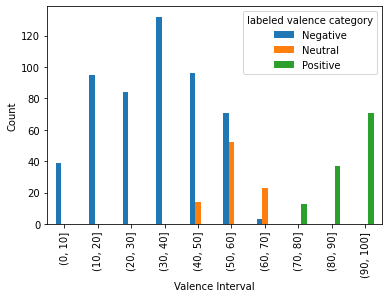

In [21]:
plt.figure()
#To plot multi-index dataframes, unstack can be used to plot one index with another
#Pass in the Valence column since that's the column of interest
a=temp_df['Valence'].unstack(level=0).plot(kind='bar')
plt.xlabel('Valence Interval')
plt.ylabel('Count')
#plt.savefig(img_path+'Results/Class In Intervals.jpg', bbox_inches='tight')
plt.show()

Here, we can see that if the images were classified based on some hard threshold, some images would've been misclassified. In the study, the researchers mentioned that they had removed outliers based on standard deviations in valence ratings, but some images still seem to not match what was expected.<br/>
For example, around 70 negative images were rated between 50-60 valence score, which would be considered neutral.

The distributions of the negative and positive class also seem strange. If 0-50 and 51-100 (exclusive) are the intervals for negative and positive valence, one would expect more images around 25 and 75 respectively. However, the distribution for negative images tend to be centered around 30-40, while positive images are distributed around the right tail [90-100] of the range. There are also no positive images rated between 50-70. <br/>

What all this suggest is that there needs to be better quality check of the images that end up in the dataset. Although this is hard to control, considering people interpret images differently, there needs to be more images with diverse scores within each class; e.g.: positive images that aren't that positive. <br/>
The imbalanced distribution may also be due to having a small dataset. Based on the central limit theorem, the distribution of each class should even out with more images. However, given that webscraping is not a great option here, the only way to increase the dataset in the same way the ratings were measured, is to have people rate more images. Image augmentation would not address the score distribution, since scores remain the same across augmented images. Unless images of specific scores are targeted, the score distribution would still remain the same. Image augmentation can still be done to address the class imbalance however.

The calculated valence category based on a hard threshold can be added to the dataframe to give a sense of true and false positives/negatives for each valence category. However, given that emotion ratings are so subjective, it's unclear whether the labeled or the calculated valence category should be considered the true valence category.

In [22]:
#Create a blank column
df['calculated valence category']=''

#Assign class based on valence rating for each image
for i in range(0,len(df)):
    if df.loc[i, 'Valence'] > 50: df.loc[i, 'calculated valence category']='Positive'
    elif df.loc[i, 'Valence'] < 50: df.loc[i, 'calculated valence category']='Negative'
    else: df.loc[i, 'calculated valence category']='Neutral'

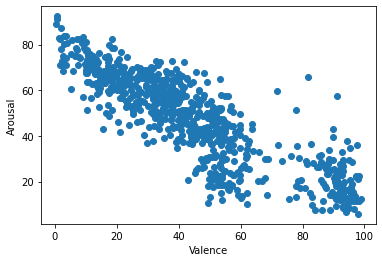

In [23]:
#Plot the valence X arousal space
plt.figure()
plt.scatter(df['Valence'], df['Arousal'])
plt.xlabel('Valence')
plt.ylabel('Arousal')
#plt.savefig(img_path+'Results/.jpg', bbox_inches='tight')
plt.show()

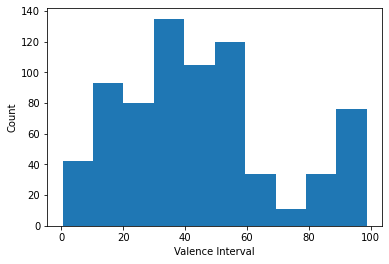

In [24]:
#Plot the distribution of valence ratings as a whole
plt.figure()
plt.hist(df['Valence'])
plt.xlabel('Valence Interval')
plt.ylabel('Count')
#plt.savefig(img_path+'Results/.jpg', bbox_inches='tight')
plt.show()

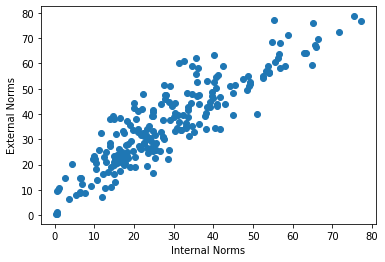

In [25]:
#Plot the internal X external norms space
plt.figure()
plt.scatter(df['Internal norms'], df['External norms'])
plt.xlabel('Internal Norms')
plt.ylabel('External Norms')
#plt.savefig(img_path+'Results/Class In Intervals.jpg', bbox_inches='tight')
plt.show()

We can look at the range valence scores in each class directly to see how differently images under the same category are being rated.

In [26]:
#Group the dataframe by the labeled valence category, then call on the Valence column to get the score associated with each class
#To get the range of each class, find the minimum and maximum of the valence score within each class
#To call on a specific class, slice the minimum and maximum scores on what class you want to look at
print('Negative range:', df.groupby(['labeled valence category'])['Valence'].min()['Negative'],
      '-',df.groupby(['labeled valence category'])['Valence'].max()['Negative'], '\n',
     'Neutral range:', df.groupby(['labeled valence category'])['Valence'].min()['Neutral'],
      '-',df.groupby(['labeled valence category'])['Valence'].max()['Neutral'], '\n',
     'Positive range:', df.groupby(['labeled valence category'])['Valence'].min()['Positive'],
      '-',df.groupby(['labeled valence category'])['Valence'].max()['Positive'])

Negative range: 0.414 - 63.66 
 Neutral range: 40.953 - 68.85 
 Positive range: 71.86 - 98.73700000000001


Although it seems like a good idea to remove the images that do not fall under the right class based on the valence score, given that the dataset is already very small, it's may be more beneficial to leave the images in. It could be difficult to find open image datasets that have human emotion ratings. 

In [27]:
#Save results to a csv file to prevent the need to run dataframe manipulation steps every time
df.to_csv(data_path+'Study Results/Summary.csv', index=False)